# Mini-Challenge 1

Modul: Deep Learning  
Thema: Hyperparameter und Model Tuning  
Student: Si Ben Tran  
Fachexperte: Martin Melchior  
Abgabetermin: Ende FS23   

Ziel:  
Implementiere, trainiere und validiere ein Neuronales Netzwerk Modell für einen
Klassifikationstask mit geeignetem Dataset. Der zu modellierende Task und die dazu
passenden Daten sollen am Anfang der Mini-Challenge individuell vereinbart werden. Dabei
können die Studierenden auch ihre Wünsche einbringen und Task/Datensatz vorschlagen.
Dabei ist aber darauf zu achten, dass der Fokus auf das Training und die Evaluation gelegt
und nicht zu viel Zeit mit Datenbeschaffung, -Analyse und -Vorverarbeitung verbraucht wird.
Der Datensatz sollte auch nicht zu gross sein, um viele verschiedene Modell- und
Parametervarianten evaluieren zu können. Ausserdem sollten nicht zu ausgeklügelte
komplexe Modell-Architekturen untersucht werden. Ein MLP für die Klassifikation allenfalls
mit ein paar CNN-Layern für Feature-Extraktion sollte ausreichen.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
• Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
• Klare, gut-strukturierte Umsetzung.  
• Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
• Vernünftiger Umgang mit (Computing-)Ressourcen.  
• Verständliche Präsentation der Ergebnisse.  


---

# Arbeitsschritte

## Schritt 1: Auswahl Task / Datensatz  

**Absprache/Beschluss** mit Fachcoach über Daten/Task.

**1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task
gelernt werden soll.**  

Gedanken: Ich moechte gerne ein CNN-Modell zur Klassifizierung des CIFAR-10-Datensatzes zu trainieren, um ein besseres Verständnis von CNNs zu erlangen und die Hyperparameter mithilfe von Weights & Biases-Integration zu optimieren.

**2. Diskutiere die Idee mit dem Fachcoach.**  

Diskussion: Es wurde mal vorerst vereinbart, am 16.04.23 die Minichallenge 1 abzugeben und die Aufgaben zu erledigen. 


---

## Schritt 2: Daten Kennenlernen
Wie erwähnt, sollte dieser Schritt nicht viel Zeit beanspruchen, da der Datensatz einfach
sein soll!


**1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse
der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der
Klassen.**


In [1]:
# Libraries Laden

## PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn 
# import torch.nn.functional as F for activation functions
import torch.nn.functional as F

# import pytorch optimizer for training
import torch.optim as optim

# import summary function from torchsummary
from torchsummary import summary

## Data Science Libraries 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## import wandb for logging and tracking
import wandb

# Device Einstellungen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('torch cuda is available:', torch.cuda.is_available())
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    print('No GPU available, using the CPU instead.')

# wandb login 
print("Successfull wandb login: ", wandb.login())

torch cuda is available: False
Using device: cpu
No GPU available, using the CPU instead.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 7ben18. Use `wandb login --relogin` to force relogin


Successfull wandb login:  True


In [2]:
# create function for getting cifar10 dataset
def get_dataset(data_dir = './data', dimension_info = True):
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                            download=True, transform=transforms.ToTensor())
    valset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                             download=True, transform=transforms.ToTensor())
    if dimension_info:
        print("Trainingsset: Anzahl Bilder {}, Hoehe {}, Breite {}, Farbkanäle {}".format(trainset.data.shape[0], trainset.data.shape[1], trainset.data.shape[2], trainset.data.shape[3]))
        print("Valset: Anzahl Bilder {} , Hoehe {}, Breite {}, Farbkanäle {}".format(valset.data.shape[0], valset.data.shape[1], valset.data.shape[2], valset.data.shape[3]))

    return trainset, valset

In [ ]:
# get dataset
trainset, valset = get_dataset()

In [ ]:
# create a function for plotting 10x10 grid
def plot_10x10_grid(data, title):
    '''
    plotting 10x10 grid of images
    '''
    fig, ax = plt.subplots(10, 10, figsize=(15, 15))
    for i in range(10):
        for j in range(10):
            # plot image 
            ax[i, j].imshow(data.data[i*10+j])
            # add title to each subplot
            ax[i, j].set_title(data.classes[data.targets[i*10+j]])
            # set axis labeling off
            ax[i, j].axis('off')
            # set grid off
            ax[i, j].grid(False)
    # add title and adjust layout
    plt.suptitle(title, fontsize=20, y = 1.005)
    plt.tight_layout()
    plt.show()

# plot testset 10x10 grid
plot_10x10_grid(trainset, 'Trainset CIFAR-10')
plot_10x10_grid(valset, 'Valset CIFAR-10')

In [ ]:
# Visualisierung Anzahl Bilder Pro Klasse  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot barplot
sns.barplot(x=trainset.classes, y=np.bincount(trainset.targets), ax=ax1)
sns.barplot(x=valset.classes, y=np.bincount(valset.targets), ax=ax2)
# set title and labels
ax1.set_title("CIFAR-10 Trainset", fontsize=15)
ax2.set_title("CIFAR-10 Valset", fontsize=15)
ax1.set_ylabel("Anzahl Bilder", fontsize=10)
ax1.set_xlabel("Klassen", fontsize=10)
ax2.set_ylabel("Anzahl Bilder", fontsize=10)
ax2.set_xlabel("Klassen", fontsize=10)
# rotate xticklabels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
# add suptitle
fig.suptitle("Anzahl Bilder pro Klasse in Train- und Valset", fontsize=20, y = 1.02)
# add number of images to barplot
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
plt.show()


In [ ]:
# get the distribution of the colour channels
def get_channel_distribution(data):
    '''
    get the distribution of the colour channels
    '''
    # create empty list for each channel
    r = []
    g = []
    b = []
    # calculate the mean for each 
    for i in range(data.shape[0]):
        r.append(np.mean(data[i, :, :, 0]))
        g.append(np.mean(data[i, :, :, 1]))
        b.append(np.mean(data[i, :, :, 2]))
    return r, g, b

# get the distribution of the colour channels
r_train, g_train, b_train = get_channel_distribution(trainset.data)
r_test, g_test, b_test = get_channel_distribution(valset.data)

# plot the distribution of the colour channels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(r_train, ax=ax1, color='r', alpha = 0.5)
sns.histplot(g_train, ax=ax1, color='g', alpha = 0.5)
sns.histplot(b_train, ax=ax1, color='b', alpha = 0.5)
sns.histplot(r_test, ax=ax2, color='r', alpha = 0.5)
sns.histplot(g_test, ax=ax2, color='g', alpha = 0.5)
sns.histplot(b_test, ax=ax2, color='b', alpha = 0.5)
ax1.set_title("CIFAR-10 Trainset, Farbkanalverteilung", fontsize=15)
ax2.set_title("CIFAR-10 Testset, Farbkanalverteilung", fontsize=15)
ax1.set_ylabel("Häufigkeit", fontsize=10)
ax1.set_xlabel("Farbwert", fontsize=10)
ax2.set_ylabel("Häufigkeit", fontsize=10)
ax2.set_xlabel("Farbwert", fontsize=10)
fig.suptitle("Farbkanalverteilung", fontsize=20, y = 1.02)
plt.show()


**2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.**

In [8]:
def get_dataloader(normalize=True, batch_size=64, data_dir='./data', num_workers=2, pin_memory=True, drop_last=True):
    '''
    get train and validation dataloaders for a given dataset

    dataset: the name of the dataset to be used, currently supports CIFAR10 and MNIST
    normalize: a boolean indicating whether to apply normalization to the data
    batch_size: the batch size for loading data
    data_dir: the directory where the data will be downloaded and stored
    num_workers: the number of worker processes for loading data
    pin_memory: a boolean indicating whether to pin the memory for faster data transfer
    drop_last: a boolean indicating whether to drop the last incomplete batch when the dataset size is not divisible by the batch size
    '''
    # define transforms
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        transform = transforms.Compose([transforms.ToTensor()])

    # define train and validation datasets
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    # define train and validation dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)

    return trainloader, valloader

In [9]:
# get train and validation dataloaders for CIFAR10 dataset with normalization and batch size of 64
trainloader, valloader = get_dataloader(normalize=True, batch_size=5, data_dir='./data', num_workers=2, pin_memory=True, drop_last=True)

# dimension of trainloader and valloader batches
print(f"Trainloader batch size: {trainloader.batch_size}")
print(f"Valloader batch size: {valloader.batch_size}")


Files already downloaded and verified
Files already downloaded and verified
Trainloader batch size: 5
Valloader batch size: 5


---

## Schritt 3: Aufbau Modellierung

**Absprache/Beschluss** mit Fachcoach über die zu untersuchenden Varianten (Schritte 4)

**1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest.
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.**

Als Evaluierungsmetrik verwende ich die Accuracy, da es sich um ein Klassifikationsproblem handelt und die Verteilungen der Klassen ueber den ganzen Datensatz hinweg gleichmaessig verteilt sind, sowohl im Trainingsdatensatz als auch im Testdatensatz.

Die accuracy berechnet sich wie folgt:

$$
\text{accuracy} = \frac{\text{Anzahl korrekt klassifiziert}}{\text{Anzahl aller Beispiele}}
$$

Als Loss Funktion nutzen wir die Cross-Entropy Loss, da es sich um ein multiple Klassifikationsproblem handelt. Die Cross-Entropy Loss berechnet sich wie folgt:

$$
\text{Cross-Entropy Loss} = -\sum_{i=1}^{n} \sum_{j=1}^{m} y_{ij} \log(\hat{y}_{ij})
$$


Wir erstellen verschiedene Modelle und untersuchen dann das beste Modell.
Folgend werden die ersten Modelle aufgelistet und beschrieben:  

MLP_1: Multi-Layer Perceptron (MLP) mit 4 Layers und der ReLU Aktivierungsfunktion.  
MLP_2: Multi-Layer Perceptron (MLP) mit 6 Layers und der ReLU Aktivierungsfunktion.

CNN_1: Convolutional Neural Network mit 2 Convolutional Layers und 3 Fully Connected Layers  
CNN_2: Convolutional Neural Network mit 3 Convolutional Layers und 3 Fully Connected Layers

---


**2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu
evaluieren.**

Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. [W&B](https://wandb.ai/site))

Hier werden einige wichtige Begriffe definiert bevor wir mit der Implementierung des Modells beginnnen:

**Batch Size**   
Die Batch Size definiert die Anzahl Bilder, die gleichzeitig in das Modell gegeben werden. 
Bsp. hat unser Cifar10 Datensatz 50000 Trainingsbilder, eine batchsize = 4 bedeutet, dass wir 4 Bilder gleichzeitig in das Modell geben und gesammthaft 12500 batches haben. (50000/4 = 12500)

**Epoche**  
Eine Epoche ist ein Durchlauf durch den gesamten Trainingsdatensatz. Bsp. hat unser Cifar10 Datensatz 50000 Trainingsbilder, eine batchsize = 4 bedeutet, dass wir 4 Bilder gleichzeitig in das Modell geben und gesammthaft 12500 batches haben. (50000/4 = 12500). Wenn wir nun 10 Epochen trainieren, dann haben wir 12500 * 10 = 125000 Bilder trainiert.

**WANDB Sweeps**  
Alle Wandb Sweeps sind unter dem folgenden [Link](https://wandb.ai/7ben18/del-mc1/sweeps) aufrufbar. 
Die ersten Sweep sind testrun die entsprechend nummeriert sind. Diese Runs haben für die Minichallenge 1 keine relevanz.   
Die Relevanten Sweeps werden bsp: A4-a-run-1,  
- A4 steht für den Schritt 4 der Minichallenge
- a steht für die erste Subaufgabe
- run-0 steht für den ersten durchlauf des Codes. 

### Multi Layer Perceptron

In [10]:
class MLP_1(nn.Module):
    '''
    Multi Layer Perceptron 4 Layers
    '''
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(32*32*3, 256)
        # first hidden layer
        self.fc2 = nn.Linear(256, 128)
        # second hidden layer
        self.fc3 = nn.Linear(128, 64)
        # output layer
        self.fc4 = nn.Linear(64, 10)

    
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0), -1)
        # input layer
        x = self.fc1(x)
        # relu activation
        x = F.relu(x)
        # first hidden layer
        x = self.fc2(x)
        # relu activation
        x = F.relu(x)
        # second hidden layer
        x = self.fc3(x)
        # relu activation
        x = F.relu(x)
        # output layer
        x = self.fc4(x)
        return x
    
# create mlp model with 4 layers
model_mlp_1 = MLP_1().to(device)

# print model architecture
print("MLP with 4 Layers")
summary(model_mlp_1, (3, 32, 32))

class MLP_2(nn.Module):
    '''
    Multi Layer Perceptron with 6 Layers
    '''
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(32*32*3, 512)
        # first hidden layer
        self.fc2 = nn.Linear(512, 256)
        # second hidden layer
        self.fc3 = nn.Linear(256, 128)
        # third hidden layer
        self.fc4 = nn.Linear(128, 64)
        # fourth hidden layer
        self.fc5 = nn.Linear(64, 32)
        # output layer
        self.fc6 = nn.Linear(32, 10)
    
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0), -1)
        # input layer
        x = self.fc1(x)
        # relu activation
        x = F.relu(x)
        # first hidden layer
        x = self.fc2(x)
        # relu activation
        x = F.relu(x)
        # second hidden layer
        x = self.fc3(x)
        # relu activation
        x = F.relu(x)
        # third hidden layer
        x = self.fc4(x)
        # relu activation
        x = F.relu(x)
        # fourth hidden layer
        x = self.fc5(x)
        # relu activation
        x = F.relu(x)
        # output layer
        x = self.fc6(x)
        return x
    
# crete mlp model with 6 layers
model_mlp_2 = MLP_2().to(device)

# print model architecture
print("MLP with 6 Layers")
summary(model_mlp_2, (3, 32, 32))


MLP with 4 Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.16
Estimated Total Size (MB): 3.18
----------------------------------------------------------------
MLP with 6 Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
     

### Convuliutional Neural Network

In [11]:
class CNN_1(nn.Module):
    '''
    Convolutional Neural Network with 2 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 16*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x

# creating model objects and get the number of parameters
model_cnn_1 = CNN_1().to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_1, (3, 32, 32))

class CNN_2(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 32*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_2 = CNN_2().to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_2, (3, 32, 32))

CNN with 2 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
CNN with 3 Convolutional Layers and 3 Fully Con

### Model Training

In [12]:
# creating a train function for training the model, parameters are: criterion, optimzer, model and dataloader 
def train_modell(model, dataloader, criterion, optimizer, num_epochs=1, verbose=False):
    '''
    This function trains a given model for a given number of epochs and returns the loss and accuracy for each epoch

    model: example: model_cnn_1
    dataloader: trainloader or valloader
    criterion: nn.CrossEntropyLoss()
    optimzer: optim.SGD(model.parameters(), lr = )
    '''
    num_of_total_batches = len(dataloader)
    num_of_total_samples = len(dataloader.dataset)
    epoch_loss = 0
    epoch_correct_predicted = 0

    # iteriere durch alle batches im dataloader
    for batch_index, (images, labels) in enumerate(dataloader):

        # images has dimension [batch_size, colour channel, width, height]
        # labels is a tensor with (list) with the class number

        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        labels_predict = model(images)

        # calculate the loss based on criterion
        loss = criterion(labels_predict, labels)

        # Backward Propagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate metric loss and accuracy
        epoch_loss = epoch_loss + loss
        epoch_correct_predicted = epoch_correct_predicted + (labels_predict.argmax(axis=1) == labels).type(torch.float).sum().item()
    
    # calculate the average loss and accuracy for the epoch
    epoch_avg_loss = epoch_loss / num_of_total_batches
    epoch_accuracy = epoch_correct_predicted / num_of_total_samples

    if verbose:
        print(f"Train Loss: {epoch_avg_loss}, Train Accuracy: {epoch_accuracy}")
        
    return epoch_avg_loss, epoch_accuracy
    
# create a test function for testing the model, parameters are: criterion, model and dataloader
def test_model(model, dataloader, criterion, verbose=False):
    '''
    This function tests a given model and returns the loss and accuracy 

    model: example: model_cnn_1
    dataloader: trainloader or valloader
    criterion: nn.CrossEntropyLoss()
    '''

    num_of_total_batches = len(dataloader)
    num_of_total_samples = len(dataloader.dataset)
    epoch_loss = 0
    epoch_correct_predicted = 0

    # iteriere durch alle batches im dataloader
    for batch_index, (images, labels) in enumerate(dataloader):

        # images has dimension [batch_size, colour channel, width, height]
        # labels is a tensor with (list) with the class number

        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        labels_predict = model(images)

        # calculate the loss based on criterion
        loss = criterion(labels_predict, labels)

        # calculate metric loss and accuracy
        epoch_loss = epoch_loss + loss
        epoch_correct_predicted = epoch_correct_predicted + (labels_predict.argmax(axis=1) == labels).type(torch.float).sum().item()

    # calculate the average loss and accuracy for the epoch
    epoch_avg_loss = epoch_loss / num_of_total_batches
    epoch_accuracy = epoch_correct_predicted / num_of_total_samples

    if verbose:
        print(f"Validation Loss: {epoch_avg_loss}, Validation Accuracy: {epoch_accuracy}")

    return epoch_avg_loss, epoch_accuracy


checkpoint

In [ ]:
# testing implementation of train and test function
#SGD_optimizer = optim.SGD(model_cnn_1.parameters(), lr = 0.01)
#criterion_crossentropy = nn.CrossEntropyLoss()

#for i in range(2):
#    train_modell(model_mlp_2, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer, verbose=True)
#    test_model(model_mlp_2, valloader, criterion=criterion_crossentropy, verbose=True)

### Trainieren von Modellen

**3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann.**

In [13]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001]
        },
        'batch_size': {
            'values': [1]
        },
        'num_epochs': {
            'values': [10]
        },
        'model': {
            'values': ['MLP_1', 'MLP_2', 'CNN_1', 'CNN_2', ]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")


# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    
    if models == "MLP_1":
        model = MLP_1().to(device)
    elif models == "MLP_2":
        model = MLP_2().to(device)
    elif models == "CNN_1":
        model = CNN_1().to(device)
    elif models == "CNN_2":
        model = CNN_2().to(device)
        
    # create model
    #model = MLP_1().to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

Create sweep with ID: 88eys7m7
Sweep URL: https://wandb.ai/7ben18/del-mc1/sweeps/88eys7m7


wandb: Agent Starting Run: fleexe2y with config:
wandb: 	batch_size: 1
wandb: 	lr: 0.001
wandb: 	model: MLP_1
wandb: 	num_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Files already downloaded and verified
Files already downloaded and verified


### 3 Wandb Sweeps

Durch den [Run](https://wandb.ai/7ben18/del-mc1/sweeps/05ibw9wv?workspace=user-7ben18) konnten wir unsere Modelle sowie Trainingsfunktionalitäten austesten. Wir erkennen ganz gut, das unsere Modelle die Daten gelernt haben. Weiter können wir nun auch schon die Modelle bezüglich der Train-Accuracy und Validierungs-Accuracy miteinander vergleichen. 

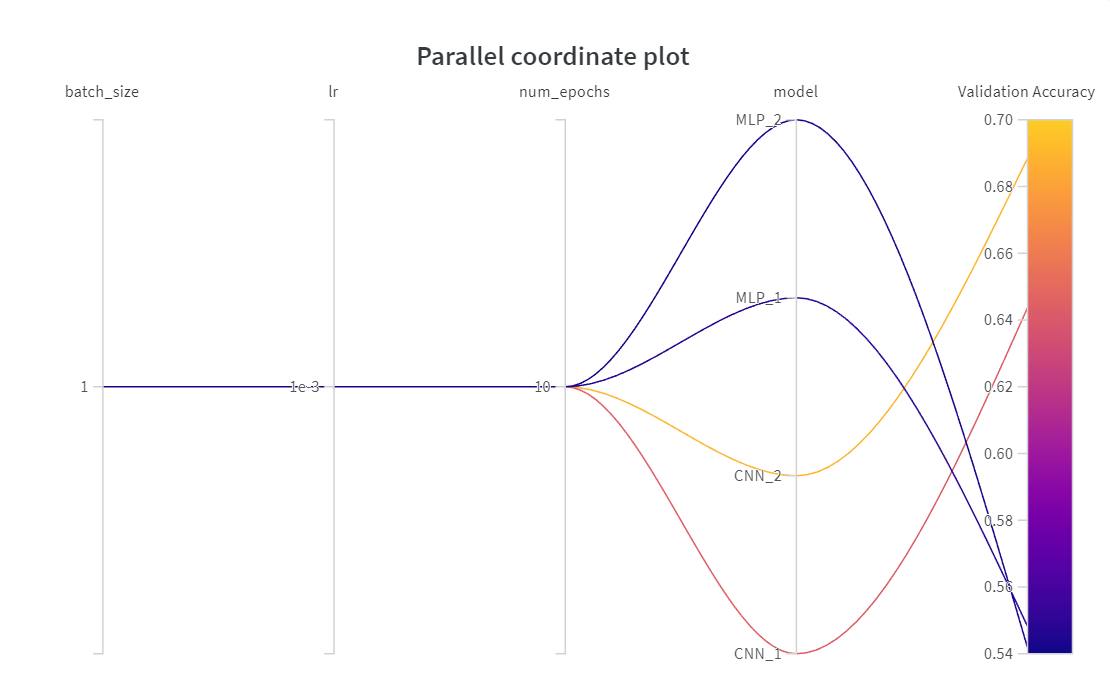

Wir erkennen, dass unser CNN_2 Modell die höchste Accuracy sowohl beim Trainings- und Validierungsaccuray erreicht hat. 
sparkling-sweep-4 run konnte mit einer Learning Rate von 0.001 und Batch Size 1, sowie 10 Epochen ein
Train accuracy von 0.7736 und einen Validierungs Accuracy von 0.6885 erzielen

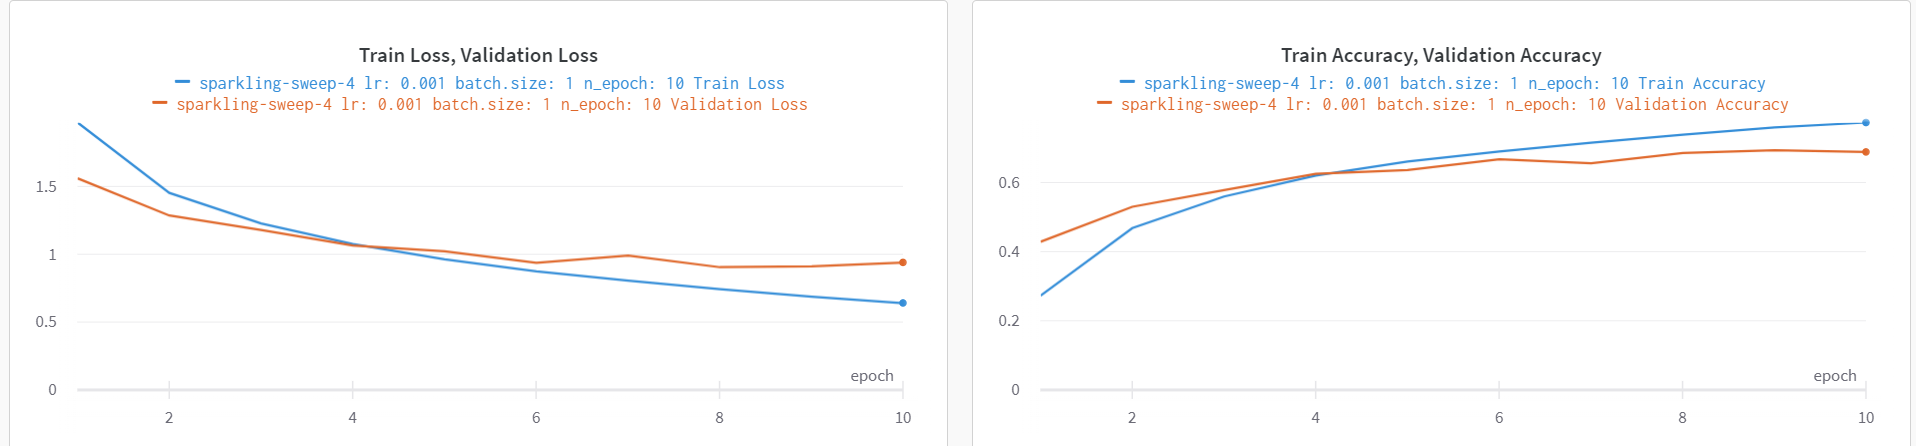

Wir erkennen beim sparkling-sweep-4 run auch, dass nach ca. 6 Epochen wir anfangen zu overfitten. 

Damit wir den Fehler der Accuracy Metriken schätzen können wurden mehrere Sweep Runs gemacht und anschliessend diese gruppiert.
Wir erkennen, das die Fehler der Trainings Accuracy und Validierungs Accuracy mit....

---

## Schritt 4: Evaluation

Bei der Evaluation ist darauf zu achten, dass das Vorgehen stets möglichst reflektiert
erfolgt und versucht wird, die Ergebnisse zu interpretieren. Am Schluss soll auch ein
Fazit gezogen werden, darüber welche Variante am besten funktioniert.

### 1. Training mit SGD, ohne REG, ohne BN:  
Untersuche verschiedene Modelle unterschiedlicher Komplexität, welche geeignet
sein könnten, um das Klassifikationsproblem zu lösen. Verwende Stochastic Gradient
Descent - ohne Beschleunigung, ohne Regularisierung (REG) und ohne Batchnorm
(BN). Überlege Dir für jeden Fall, wie die Gewichte initialisiert werden sollen.

**a. Für jedes Modell mit gegebener Anzahl Layer und Units pro Layer führe ein
sorgfältiges Hyper-Parameter-Tuning durch (Lernrate, Batch-Grösse). Achte
stets darauf, dass das Training stabil läuft. Merke Dir bei jedem Training, den
Loss, die Performance Metrik(en) inkl. Schätzfehler, die verwendete Anzahl
Epochen, Lernrate und Batch-Grösse.**

Sweep Name startet mit: A2-1a-runX

In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.1, 0.01]
        },
        'batch_size': {
            'values': [64, 128, 256]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['MLP_1', 'MLP_2', 'CNN_1', 'CNN_2', ]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    
    if models == "MLP_1":
        model = MLP_1().to(device)
    elif models == "MLP_2":
        model = MLP_2().to(device)
    elif models == "CNN_1":
        model = CNN_1().to(device)
    elif models == "CNN_2":
        model = CNN_2().to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

### 4a Wandb Sweeps

Nachdem der erste [Run](https://wandb.ai/7ben18/del-mc1/sweeps/7ggfer4g?workspace=user-7ben18) von Aufgabe 4a auf CSCS nach 1.5h durchgelaufen ist erhielt ich den Parallel coordinate Plot mit diversen Hyperparameter Tuning durch verschiedene Modelle. 
Es wurden nicht so viele Hyperparameter Tuning betrieben, da ich nicht wusste wie lange die Laufzeit auf CSCS laufen würde. Aus diesem Grund blieben ich bei Gesamthaft 24 Runs.

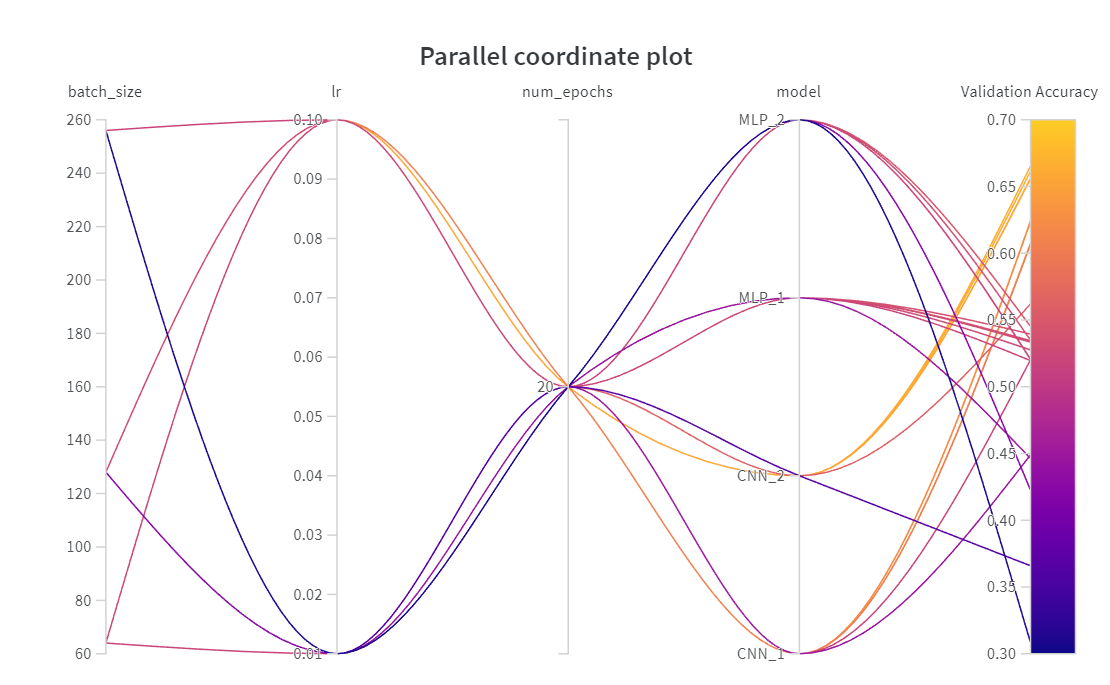

Wir erkenne im Plot, dass vorallem CNN_2 einen hohen Validation Accuracy erreicht hat.  
Selektieren wir die 4 hoechsten Runs nach Validiation Accuracy und betrachten diese genauer.

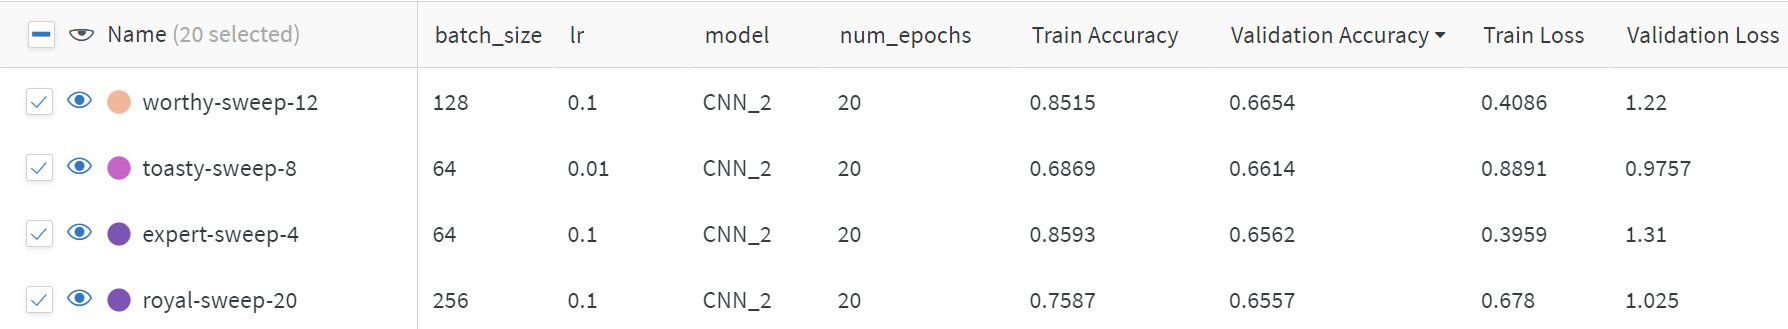

Die Top 4 Runs sind alle von CNN_2, dabei konnte die Learning Rate von 0.1, 20 Epochen und eine Batch Size von 128 das höchste Resultat erzielen. Die Train Accuracy liegt bei 0.8515. 

Damit wir den Fehler der Accuracy Metriken schätzen können, lassen wir den besten [Run](https://wandb.ai/7ben18/del-mc1/runs/749xz07k?workspace=user-7ben18) mehrmals laufen.
Um auf Wandb die Runs verlgleichen zu können, wurde ein Tag mit dem Namen 4a-1-schaetzfehler erstellt, um die Runs zu filtern zu können.

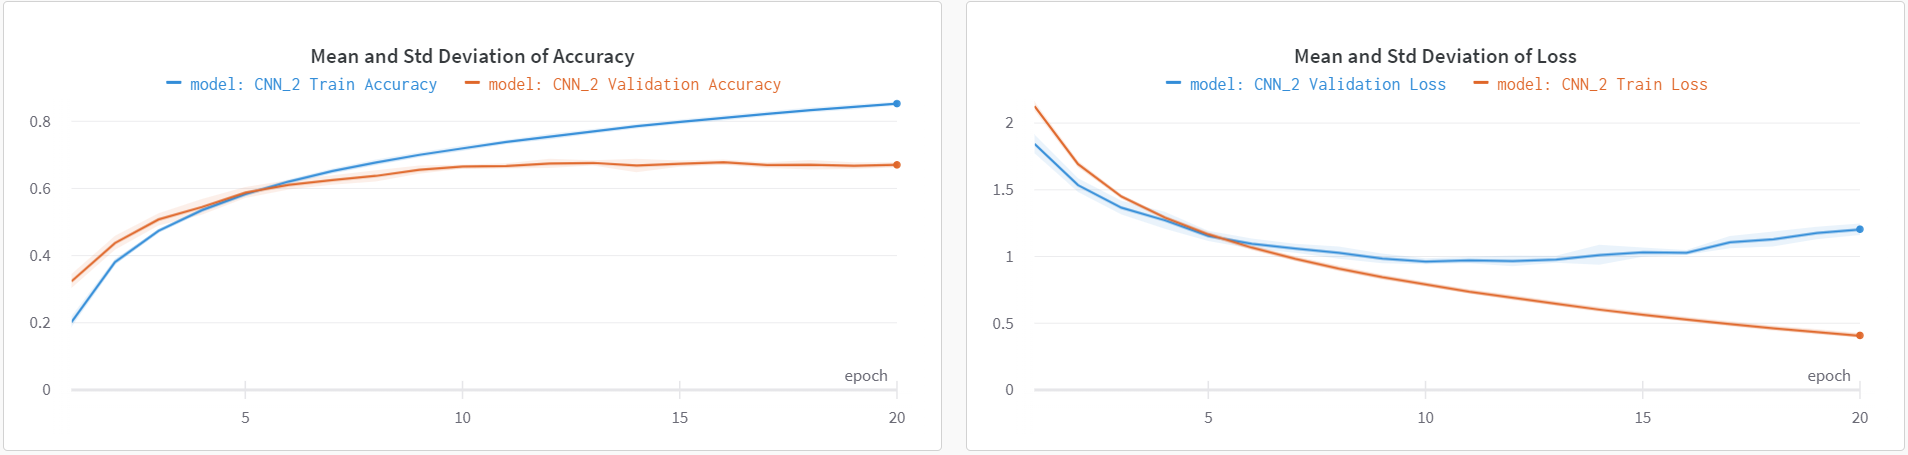
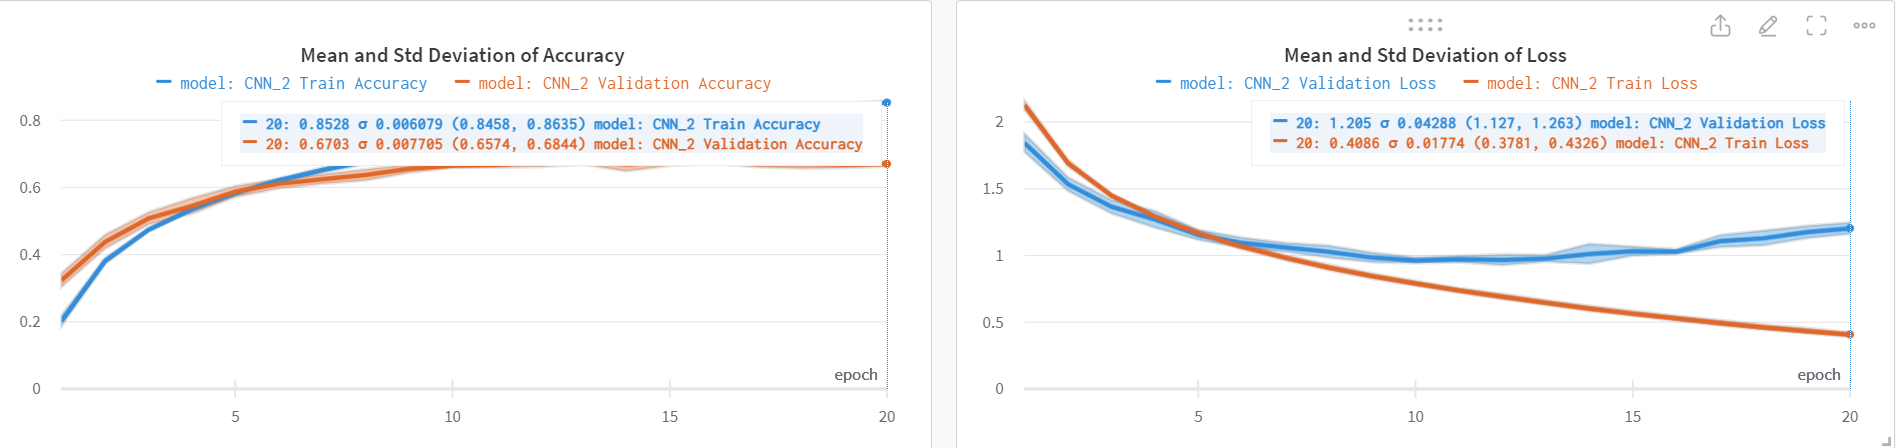

Hier eine Auflistung der Runs:

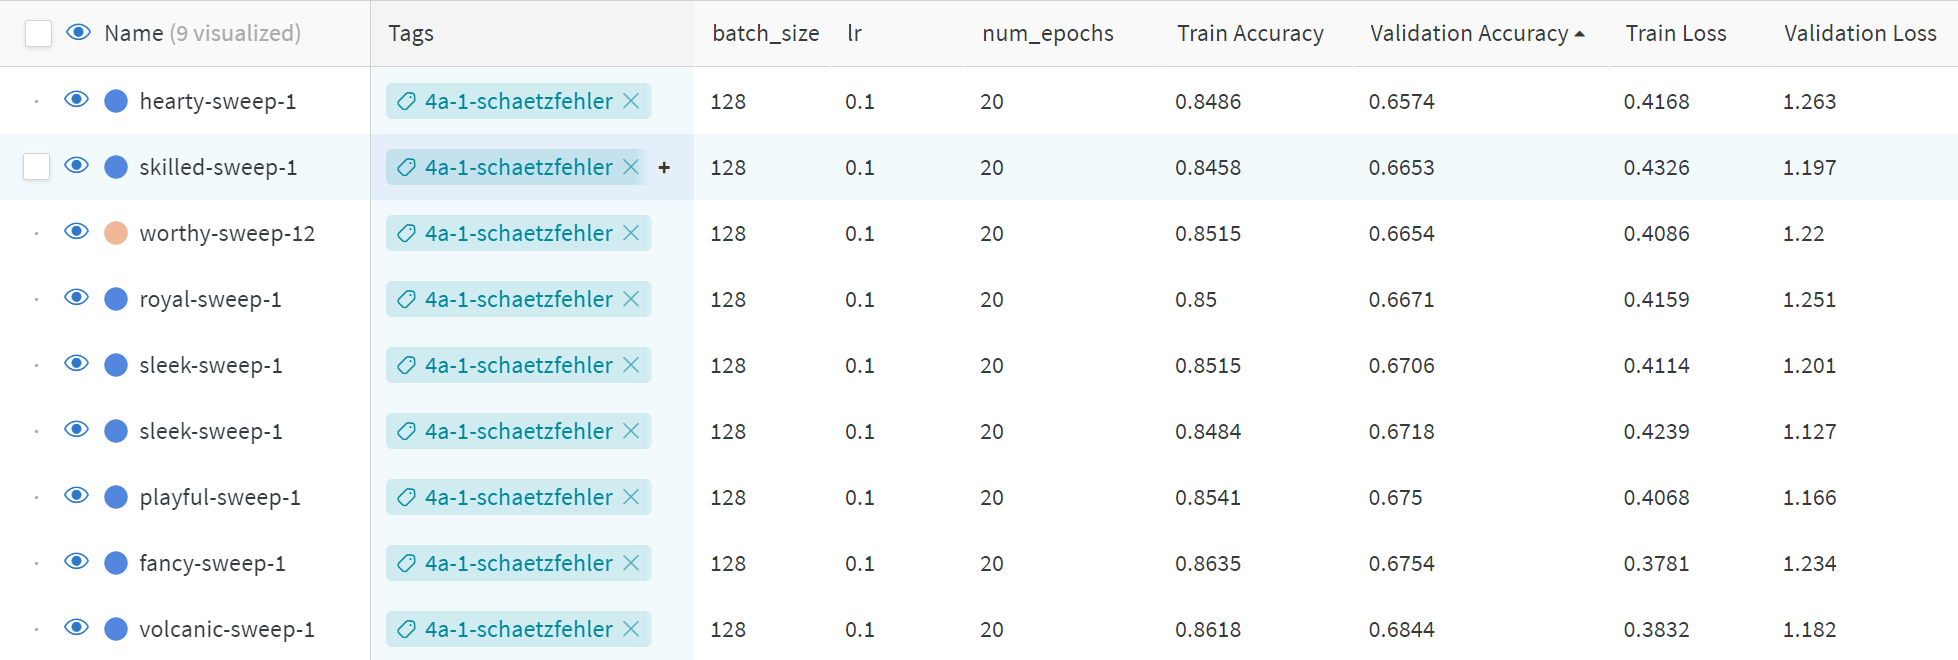

In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.1]
        },
        'batch_size': {
            'values': [128]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['CNN_2']
        },
        'runs': {
            'values': [10]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    runs = wandb.config.runs
    
    # create model
    if models == "CNN_2":
        model = CNN_2().to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for run in range(runs):
        for epoch in range(num_epochs):
            # train model
            train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
            # test model
            val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)
            # log metrics to wandb
            wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

**b. Variiere die Anzahl Layer und Anzahl Units pro Layer, um eine möglichst gute
Performance zu erreichen. Falls auch CNNs (ohne Transfer-Learning)
verwendet werden variiere auch Anzahl Filter, Kernel-Grösse, Stride, Padding.**

Sweep Name startet mit: A2-1b-runX

### Unterschiedliche CNNs mit unterschiedlichen Layern

In [ ]:
## Some CNN varaition with different number of layers and nodes
class CNN_3_1(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 1 Fully Connected Layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=32*4*4, out_features=10)  # Note: 5*5 will be changed to 4*4 if using kernel_size=3 and padding=1

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 32*4*4)  # Note: 5*5 will be changed to 4*4 if using kernel_size=3 and padding=1
        ## first fully connected layer
        x = self.fc1(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_3_1 = CNN_3_1().to(device)

# print the model architecture
print("CNN_3_1 with 3 Convolutional Layers and 1 Fully Connected Layers, max pooling 2x2, padding = 1, kernel size = 3")
summary(model_cnn_3_1, (3, 32, 32))

class CNN_3_2(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 1 Fully Connected Layers
    # remove two fully connected layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 32*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_3_2 = CNN_3_2().to(device)

# print the model architecture
print("CNN_3_2 with 3 Convolutional Layers and 1 Fully Connected Layers, max pooling 2x2, padding = 3, kernel size = 5")
summary(model_cnn_3_2, (3, 32, 32))

class CNN_3_3(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=3)
        # fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=3)
        # add fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=16*2*2, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # fourth convolutional layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        # add fifth convolutional layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        # flatten the output of the convolutional layers
        x = x.view(-1, 16*2*2)
        # first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        # third fully connected layer
        x = self.fc3(x)
        return x

# creating model objects and get the number of parameters
model_cnn_3_3 = CNN_3_3().to(device)

# print the model architecture
print("CNN_3_3 with 5 Convolutional Layers and 3 Fully Connected Layers, max pooling 2x2, padding = 3, kernel size = 5")
summary(model_cnn_3_3, (3, 32, 32))

class CNN_3_4(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=3)
        # fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=3)
        # add fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=32*2*2, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # fourth convolutional layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        # add fifth convolutional layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        # flatten the output of the convolutional layers
        x = x.view(-1, 32*2*2)
        # first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        # third fully connected layer
        x = self.fc3(x)
        return x

# creating model objects and get the number of parameters
model_cnn_3_4 = CNN_3_4().to(device)

# print the model architecture
print("CNN_3_4 with 3 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_3_4, (3, 32, 32))

In [ ]:
class CNN_3_5(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=3)
        # fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=3)
        # add fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=128*2*2, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # fourth convolutional layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        # add fifth convolutional layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        # flatten the output of the convolutional layers
        x = x.view(-1, 128*2*2)
        # first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        # third fully connected layer
        x = self.fc3(x)
        return x

# creating model objects and get the number of parameters
model_cnn_3_5 = CNN_3_5().to(device)

# print the model architecture
print("CNN_3_5 with 5 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_3_5, (3, 32, 32))

class CNN_3_6(nn.Module):
    def __init__(self, out_in_shape=256, kernel_size=5, padding=3, fc_nodes1=120, fc_nodes2=84):
        super().__init__()
        # self outout_in_shape
        self.out_in_shape = out_in_shape
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_in_shape, kernel_size=kernel_size, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=out_in_shape, out_channels=out_in_shape, kernel_size=kernel_size, padding=padding)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=out_in_shape, out_channels=out_in_shape, kernel_size=kernel_size, padding=padding)
        # fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=out_in_shape, out_channels=out_in_shape, kernel_size=kernel_size, padding=padding)
        # add fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=out_in_shape, out_channels=out_in_shape, kernel_size=kernel_size, padding=padding)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=out_in_shape*2*2, out_features=fc_nodes1)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=fc_nodes1, out_features=fc_nodes2)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=fc_nodes2, out_features=10)

    def forward(self, x):
        # first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # fourth convolutional layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        # add fifth convolutional layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        # flatten the output of the convolutional layers
        x = x.view(-1, self.out_in_shape*2*2)
        # first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        # third fully connected layer
        x = self.fc3(x)
        return x 

# creating model objects and get the number of parameters
model_cnn_3_6 = CNN_3_6(out_in_shape=256, kernel_size=5, padding=3, fc_nodes1=120, fc_nodes2=84).to(device)

# print the model architecture
print("CNN_3_6 with 5 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_3_6, (3, 32, 32))

In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.1, 0.01]
        },
        'batch_size': {
            'values': [64, 128, 256]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['CNN_3_1', 'CNN_3_2', 'CNN_3_3', 'CNN_3_4', 'CNN_3_5', 'CNN_3_6' ]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    
    if models == "CNN_3_1":
        model = CNN_3_1().to(device)
    elif models == "CNN_3_2":
        model = CNN_3_2().to(device)
    elif models == "CNN_3_3":
        model = CNN_3_3().to(device)
    elif models == "CNN_3_4":
        model = CNN_3_4().to(device)
    elif models == "CNN_3_5":
        model = CNN_3_5().to(device)
    elif models == "CNN_3_6":
        model = CNN_3_6().to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

### 4b Bemerkung:

Cuda out of Memory Fehlermehldung. 
Siehe WandB Runs, 
[A4-1b-run-failed](https://wandb.ai/7ben18/del-mc1/sweeps/vkpp6ptg?workspace=)

Evtl auf CSCS umsteigen!

Wir fahren weiter fort mit einem kleineren CNN Modell, welches nur 3 Convulutional Layers sowie 3 Fully Connected Layers hat.

In [ ]:
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [2]:
class CNN_4(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self, in_out_channel=64, kernel_size = 5, pool_size = 2, padding = 3, fc_nodes1 = 120, fc_nodes2 = 84):
        super().__init__()
        # define in_out_channel
        self.in_out_channel = in_out_channel
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=in_out_channel, kernel_size=kernel_size, padding=padding)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=in_out_channel, out_channels=in_out_channel, kernel_size=kernel_size, padding=padding)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=in_out_channel, out_channels=in_out_channel, kernel_size=kernel_size, padding=padding)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=in_out_channel*5*5, out_features=fc_nodes1)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=fc_nodes1, out_features=fc_nodes2)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=fc_nodes2, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, self.in_out_channel*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_4 = CNN_4(in_out_channel=128, kernel_size=5, pool_size=2, padding=3, fc_nodes1=120, fc_nodes2=84).to(device)

# print the model architecture
print("CNN with 3 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_4, (3, 32, 32))

CNN with 3 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 34, 34]           9,728
         MaxPool2d-2          [-1, 128, 17, 17]               0
            Conv2d-3          [-1, 128, 19, 19]         409,728
         MaxPool2d-4            [-1, 128, 9, 9]               0
            Conv2d-5          [-1, 128, 11, 11]         409,728
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Linear-7                  [-1, 120]         384,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 1,224,318
Trainable params: 1,224,318
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.99
Params size (MB): 4.67
Estimated 

In [ ]:
# define sweep configuration for CNN_4
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'min': 0.01,
            'max': 0.1,
        },
        'batch_size': {
            'values': [4, 8, 16]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['CNN_4']
        },
        'in_out_channel': {
            'min': 10,
            'max': 32,
        },
        'kernel_size': {
            'values': [5]
        },
        'padding': {
            'values': [3]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'min': 10,
            'max': 150,
        },
        'fc_nodes2': {
            'min': 10,
            'max': 100,
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    padding = wandb.config.padding
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2

    if models == "CNN_4":
        model = CNN_4(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, padding=padding, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

### Kleineres Modell CNN_5

Es wird ein kleineres Modell erstellt, weil ich probleme mit dem "Cuda out of Memory" habe.  
CNN_5 hat 2 Convulutional Layers und 3 Fully Connected Layers.

In [10]:
class CNN_5(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self, in_out_channel=32, kernel_size = 5, pool_size = 2, fc_nodes1 = 120, fc_nodes2 = 84):
        super().__init__()
        # define in_out_channel
        self.in_out_channel = in_out_channel
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=in_out_channel, kernel_size=kernel_size)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=in_out_channel, out_channels=in_out_channel, kernel_size=kernel_size)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=in_out_channel*5*5, out_features=fc_nodes1)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=fc_nodes1, out_features=fc_nodes2)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=fc_nodes2, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, self.in_out_channel*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_5 = CNN_5(in_out_channel=43, kernel_size=5, pool_size=2, fc_nodes1=95, fc_nodes2=54).to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_5, (3, 32, 32))

CNN with 2 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 43, 28, 28]           3,268
         MaxPool2d-2           [-1, 43, 14, 14]               0
            Conv2d-3           [-1, 43, 10, 10]          46,268
         MaxPool2d-4             [-1, 43, 5, 5]               0
            Linear-5                   [-1, 95]         102,220
            Linear-6                   [-1, 83]           7,968
            Linear-7                   [-1, 10]             840
Total params: 160,564
Trainable params: 160,564
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.36
Params size (MB): 0.61
Estimated Total Size (MB): 0.99
----------------------------------------------------------------


In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'min': 0.01,
            'max': 0.1,
        },
        'batch_size': {
            'values': [8, 16, 32, 64]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['CNN_5']
        },
        'in_out_channel': {
            'min': 10,
            'max': 64,
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'min': 10,
            'max': 100,
        },
        'fc_nodes2': {
            'min': 10,
            'max': 100,
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2

    if models == "CNN_5":
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

**c. Fasse die Ergebnisse zusammen in einem geeigneten Plot, bilde eine
Synthese und folgere, welche Modell-Komplexität Dir am sinnvollsten
erscheint.**

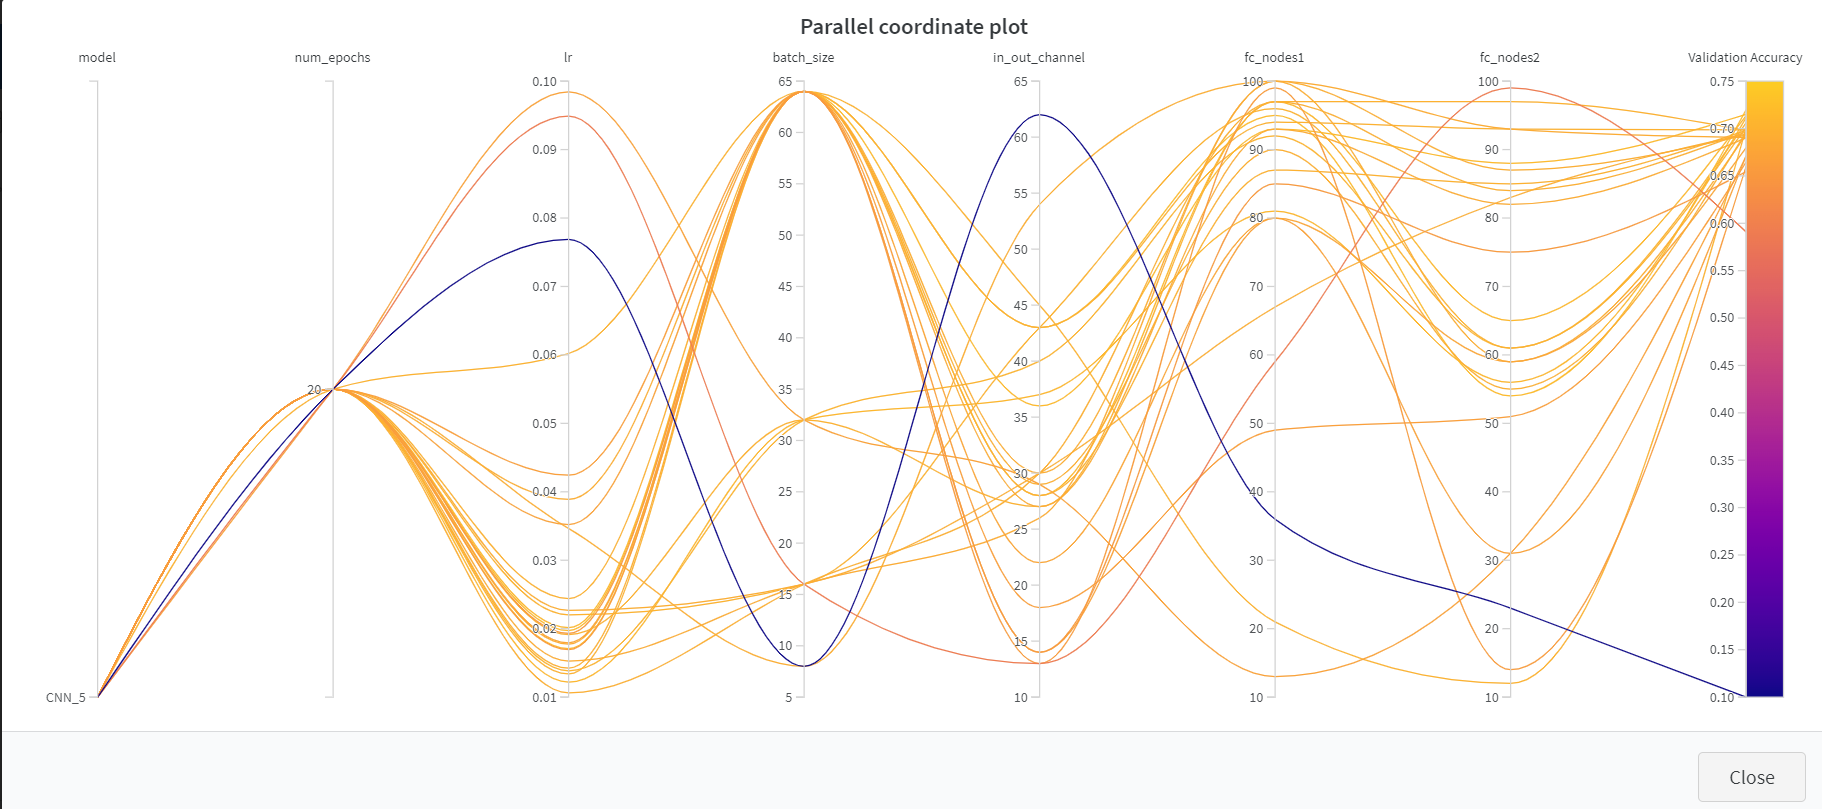

Wir erkennen im Parallel coordinate plot, dass eine tiefe Learning Rate, hohe Batch Size und eine mittlere Anzahl an in_out Filter sowie die hohen fully connected anzahl layer, eine relativ hohe validation accuracy ergibt. 

Gesamthaft wurden in diesem [sweep](https://wandb.ai/7ben18/del-mc1/sweeps/5a75ocfu?workspace=user-7ben18) 25 runs getätigt.

Falls noch genuegend Zeit vorhanden ist, kann man die Anzahl an Runs erhöhen, um die Ergebenisse zu verbessern.

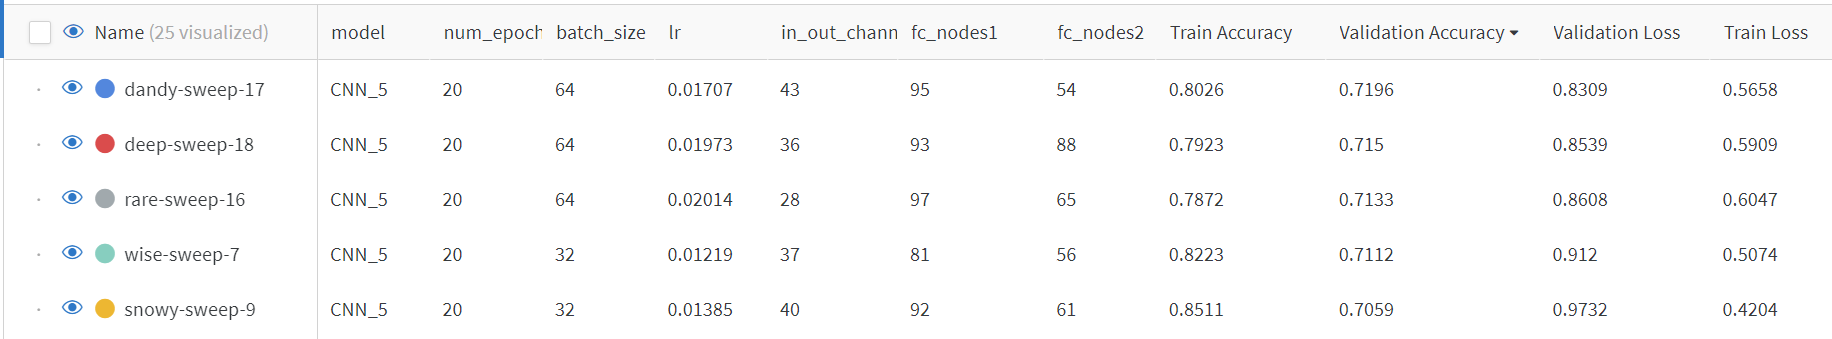

Wir nehmen die Werte vom besten Runs und nutzen die Hyperparameter in der Aufgabe zwei, Nutzen der Regularisierung.

---

### 2. Nutzen der Regularisierung

Ziehe nun verschiedene Regularisierungsmethoden bei den MLP Layern in Betracht:

**a. L1/L2 Weight Penalty**

Sweep Name startet mit: A2-2a-runX

Wir können im Optimizer die Regularisierungsmethode L2 Weight Penalty unter dem Parameter weight_decay einbauen.
Entprechend können wir einfach unser Model nehmen und müssen diese durch die Sweep Config einbauen.


In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.01707]
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [50]
        },
        'model': {
            'values': ['CNN_5']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'l2_reg': {
            'min': 0.00001,
            'max': 0.1,
        },
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    l2_reg = wandb.config.l2_reg

    if models == "CNN_5":
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=l2_reg)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

Sweep Auswertung

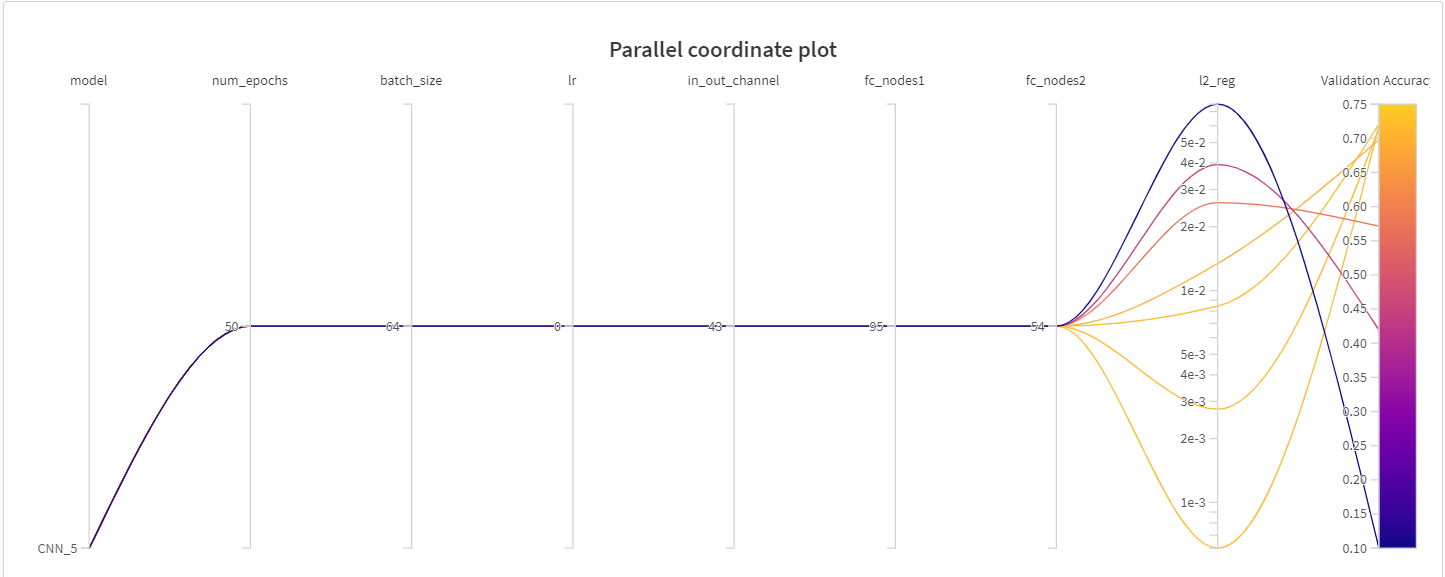

Wie erwartet hat die Regularisierung einen grossen Einfluss auf die Train- und Validationloss. Das Overfitting geschieht viel später. Um diese beobachten zu koennen wurden die Anzahl der Epochen auf 50 gestellt. 

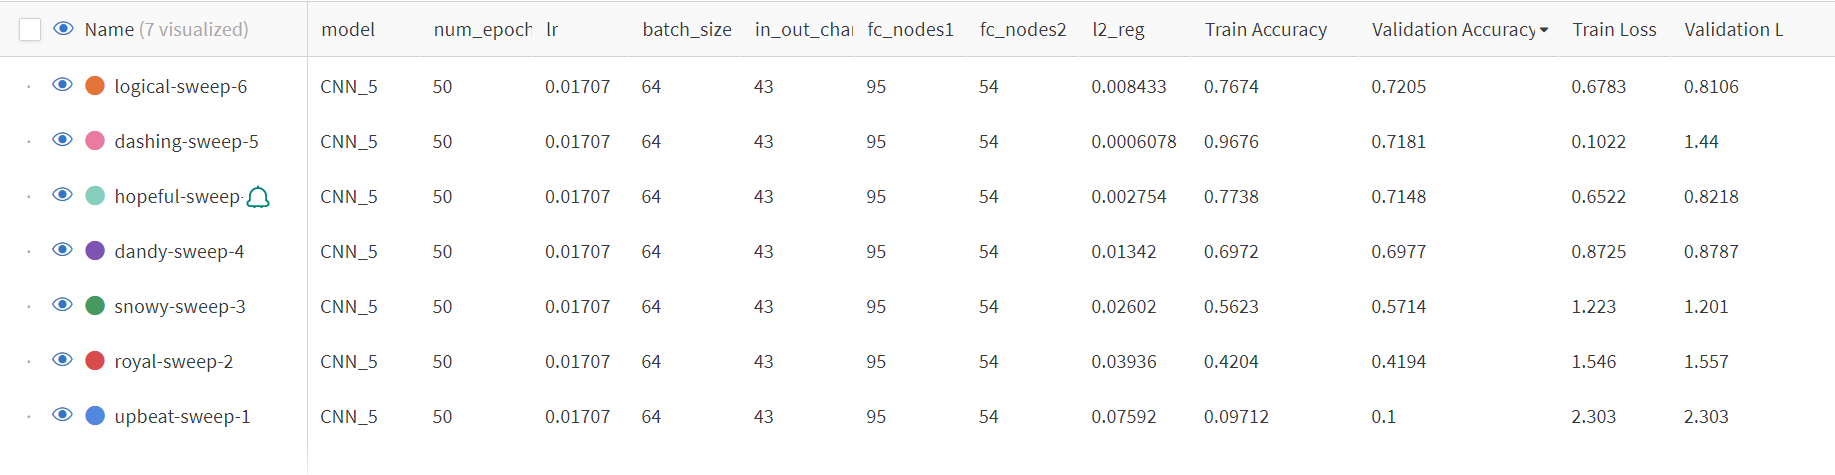

**b. Dropout**

Sweep Name startet mit: A2-2b-runX

Beim Dropout können wir uns entscheiden, in welchem Layer wir die Gewichtungen Eliminieren. 
hierbei gibt es von Pytorch für die Convulutional Layer die Dropout Funktion nn.Dropout2d(p=0.5) und für
die Fully Connected Layer nn.Dropout(p=0.5)

Im folgenden erstellen wir ein Modell, welches jeweils nach jedem Layer die Gewichtungen eliminiert.

In [11]:
class CNN_5_dropout(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self, in_out_channel=32, kernel_size = 5, pool_size = 2, fc_nodes1 = 120, fc_nodes2 = 84, droprate1 = 0.5, droprate2 = 0.5):
        super().__init__()
        # define in_out_channel
        self.in_out_channel = in_out_channel
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=in_out_channel, kernel_size=kernel_size)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=in_out_channel, out_channels=in_out_channel, kernel_size=kernel_size)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=in_out_channel*5*5, out_features=fc_nodes1)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=fc_nodes1, out_features=fc_nodes2)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=fc_nodes2, out_features=10)
        # add dropout method
        self.dropout = nn.Dropout(p=droprate1)
        # add dropout method for conv layer
        self.dropout2 = nn.Dropout2d(p=droprate2)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        ## flatten
        x = x.view(-1, self.in_out_channel*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_5_dropout = CNN_5_dropout(in_out_channel=43, kernel_size=5, pool_size=2, fc_nodes1=95, fc_nodes2=54, droprate1=0.5, droprate2=0.5).to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_5_dropout, (3, 32, 32))

CNN with 2 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 43, 28, 28]           3,268
         MaxPool2d-2           [-1, 43, 14, 14]               0
         Dropout2d-3           [-1, 43, 14, 14]               0
            Conv2d-4           [-1, 43, 10, 10]          46,268
         MaxPool2d-5             [-1, 43, 5, 5]               0
         Dropout2d-6             [-1, 43, 5, 5]               0
            Linear-7                   [-1, 95]         102,220
           Dropout-8                   [-1, 95]               0
            Linear-9                   [-1, 54]           5,184
          Dropout-10                   [-1, 54]               0
           Linear-11                   [-1, 10]             550
Total params: 157,490
Trainable params: 157,490
Non-trainable params: 0
----------------------------------

In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.01707]
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [50]
        },
        'model': {
            'values': ['CNN_5_dropout']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'dropout1': {
            'min': 0.1,
            'max': 0.9,
        },
        'dropout2': {
            'min': 0.1,
            'max': 0.9,
        },
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    droprate1=wandb.config.dropout1
    droprate2=wandb.config.dropout2

    if models == "CNN_5_dropout":
        model = CNN_5_dropout(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2, droprate1=droprate1, droprate2=droprate2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

Evaluiere den Nutzen der Regularisierung, auch unter Berücksichtigung
verschiedener Regularisierungsstärken.
Beschreibe auch kurz, was allgemein das Ziel von Regularisierungsmethoden ist
(Regularisierung im Allgemeinen, sowie auch Idee der einzelnen Methoden).
Inwiefern wird dieses Ziel im gegebenen Fall erreicht?


Regularisierungsmethoden sind Techniken, die verwendet werden, um Overfitting in maschinellen Lernmodellen zu reduzieren. Das Ziel von Regularisierung ist es, die Komplexität des Modells zu reduzieren, indem die Größe der Parameter verringert oder die Parameter auf bestimmte Weise beschränkt werden. Dadurch kann das Modell besser generalisieren, indem es die Fähigkeit erhält, auf neuen, unbekannten Daten gut zu performen.

Die Regularisierungsstärke beschreibt, wie stark die Parameterbeschränkungen durchgeführt werden sollen. Eine höhere Regularisierungsstärke bedeutet eine stärkere Beschränkung der Parameter und damit eine stärkere Reduktion der Modellkomplexität. Eine zu starke Regularisierung kann jedoch zu einer zu starken Einschränkung des Modells führen, was zu Underfitting führen kann.

---


### 3. Nutzen von Batchnorm BN (ohne REG, mit SGD)

Sweep Name startet mit: A4-3-runX

Evaluiere, ob Batchnorm etwas bringt. Beschreibe kurz, was die Idee von BN ist,
wozu es helfen soll.

Batch Normalization (BN) ist eine Technik zur Normalisierung von Daten innerhalb eines neuronalen Netzwerks.

Die Idee von BN besteht darin, die Eingabeaktivierungen jedes Layers des neuronalen Netzwerks zu normalisieren, indem sie mittels statistischer Maße wie Mittelwert und Standardabweichung auf den Null-Mittelwert und Einheitsvarianz skaliert werden. Dies hat den Vorteil, dass es das Training des Netzes beschleunigt und die Generalisierung verbessert. Darüber hinaus hilft BN, das Problem der Vanishing Gradients zu mildern, indem es dazu beiträgt, dass Gradienten besser durch das Netzwerk fliessen können.

In [12]:
class CNN_5_bn(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self, in_out_channel=32, kernel_size = 5, pool_size = 2, fc_nodes1 = 120, fc_nodes2 = 84):
        super().__init__()
        # define in_out_channel
        self.in_out_channel = in_out_channel
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=in_out_channel, kernel_size=kernel_size)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size) # 2x2 max pooling
        # batchnorm 1 
        self.bn1 = nn.BatchNorm2d(in_out_channel)
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=in_out_channel, out_channels=in_out_channel, kernel_size=kernel_size)
        # batchnorm 2
        self.bn2 = nn.BatchNorm2d(in_out_channel)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=in_out_channel*5*5, out_features=fc_nodes1)
        # batchnorm 3
        self.bn3 = nn.BatchNorm1d(fc_nodes1)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=fc_nodes1, out_features=fc_nodes2)
        # batchnorm 4
        self.bn4 = nn.BatchNorm1d(fc_nodes2)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=fc_nodes2, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, self.in_out_channel*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = self.bn4(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_5_bn = CNN_5_bn(in_out_channel=48, kernel_size=5, pool_size=2, fc_nodes1=95, fc_nodes2=54).to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_5_bn, (3, 32, 32))

CNN with 2 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 28, 28]           3,648
       BatchNorm2d-2           [-1, 48, 28, 28]              96
         MaxPool2d-3           [-1, 48, 14, 14]               0
            Conv2d-4           [-1, 48, 10, 10]          57,648
       BatchNorm2d-5           [-1, 48, 10, 10]              96
         MaxPool2d-6             [-1, 48, 5, 5]               0
            Linear-7                   [-1, 95]         114,095
       BatchNorm1d-8                   [-1, 95]             190
            Linear-9                   [-1, 83]           7,968
      BatchNorm1d-10                   [-1, 83]             166
           Linear-11                   [-1, 10]             840
Total params: 184,747
Trainable params: 184,747
Non-trainable params: 0
----------------------------------

In [ ]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.01707]
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [250]
        },
        'model': {
            'values': ['CNN_5', 'CNN_5_bn']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2

    if models == "CNN_5_bn":
        model = CNN_5_bn(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    else:
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

---

### 4. Nutzen von Adam (ohne BN, ohne / mit REG)

Sweep Name startet mit: A4-4-runX

Evaluiere, ob Du mit Adam bessere Resultate erzielen kannst.

Hier ersetzen wir en SGD Optimizer mittels Adam und nutzen dabei unser Modelle mittel l2 Regularisierung und Dropout

#### Sweep mit unterschiedlichen Learning Rate und L2 Regularisierung sowie Dropout

In [ ]:
# define sweep configuration (Nutzen von ADAM ohne BN und ohne Regularisierung)
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'min': 0.0001,
            'max': 0.1
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [20]
        },
        'model': {
            'values': ['CNN_5', 'CNN_5_dropout']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'l2_reg': {
            'min': 0.00001,
            'max': 0.1,
        },
        'dropout1': {
            'min': 0.1,
            'max': 0.9,
        },
        'dropout2': {
            'min': 0.1,
            'max': 0.9,
        },
        'optimizers': {
            'values': ['Adam', 'SGD']
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    droprate1 = wandb.config.dropout1
    droprate2 = wandb.config.dropout2
    l2_reg = wandb.config.l2_reg
    optimizers = wandb.config.optimizers

    if models == "CNN_5":
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    else:
        model = CNN_5_dropout(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2, droprate1=droprate1, droprate2=droprate2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    if optimizers == "SGD":
        optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=l2_reg)
    else:
        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=l2_reg)
        
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

#### Erkentniss aus unterschiedlichen Learning Rates und Regualrisierung L2/Dropout

Parallel Coordinate Plot mit Adam Optimizer ohne Batchnorm und mit/ohne Regularisierung

[Sweep](https://wandb.ai/7ben18/del-mc1/sweeps/3mpnx3u4?workspace=user-7ben18)

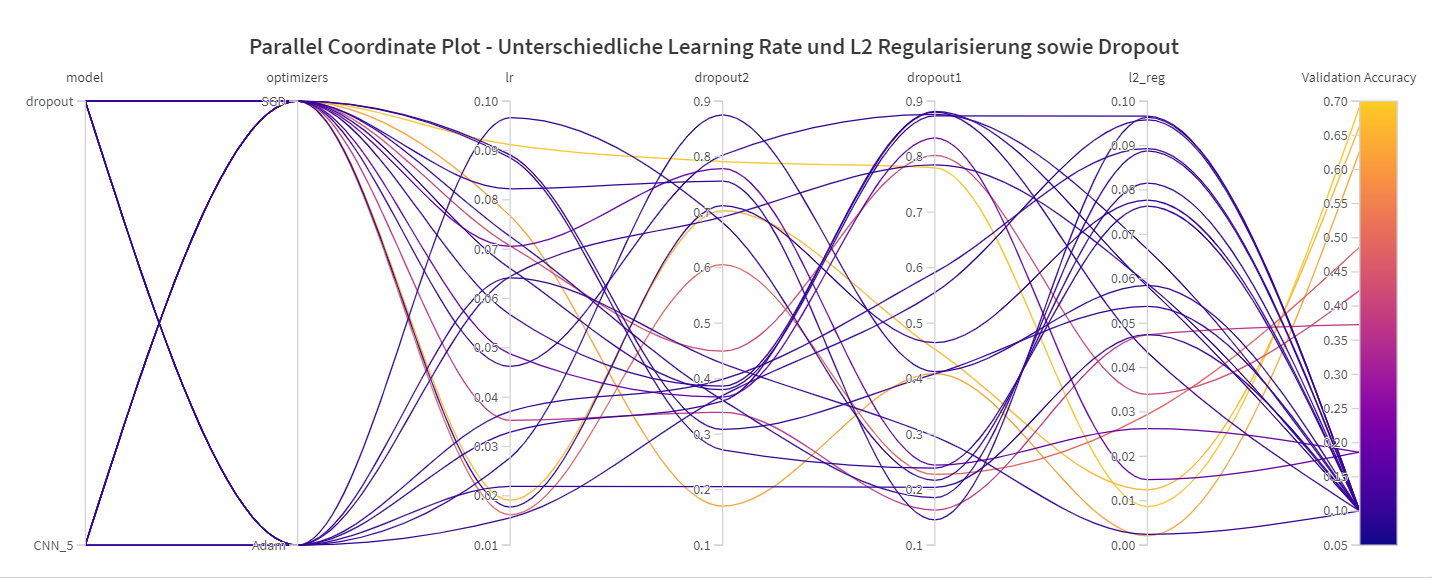

Wir erkennen deutlich, dass alle Runs mit Adam Optimizer schlechter als die von SGD Optimizer sind. Eventuell liegt diese an der Learning Rate. 

Wir fuehren einen weiteren Run durch und schauen uns nur noch diesmal die Runs mit dem Adam Optimizer an sowie unterschiedlichen Learning Rates im Range von 
0.01 bis 0.00001.

Wir schauen uns den Einfluss der Regularisierung anschliessend dann einzeln an und fuehren dann jeweils einige Runs dazu

#### Sweep mit unterschiedlichen Lernraten ohne Regularisierung

In [ ]:
# define sweep configuration (Nutzen von ADAM ohne BN und ohne und mit Regularisierung)
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'min': 0.00001,
            'max': 0.01
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [30]
        },
        'model': {
            'values': ['CNN_5']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'optimizers': {
            'values': ['Adam']
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    optimizers = wandb.config.optimizers

    if models == "CNN_5":
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    if optimizers == "Adam":
        optimizer = optim.Adam(model.parameters(), lr = lr)
        
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

#### Erkentniss der Learning Rate bei Adam Optimizer

[Sweep](https://wandb.ai/7ben18/del-mc1/sweeps/71w71gdm?workspace=user-7ben18)

Wir erkennen im Parallel Coordinate Plot, dass die Learning Rate eine grosse Rolle spielt. Je kleiner die Learning Rate, desto besser die Validation Accuracy von unserem Modell. 

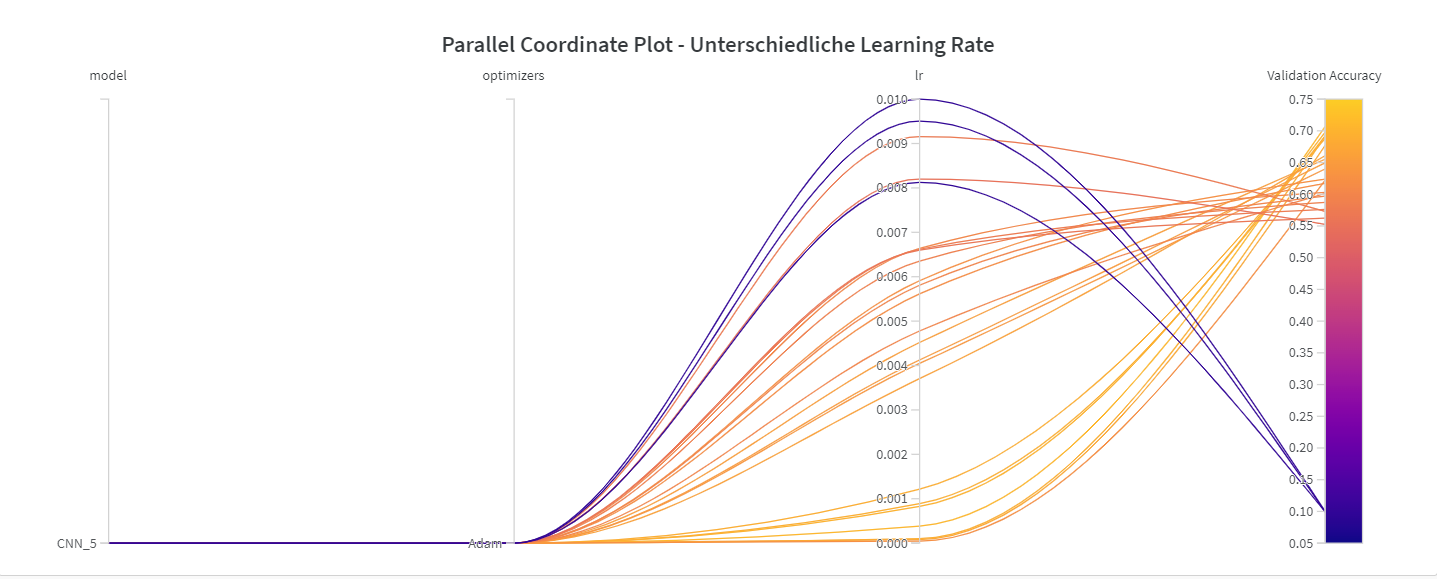



Die Top 5 Runs mit den besten Ergebnissen

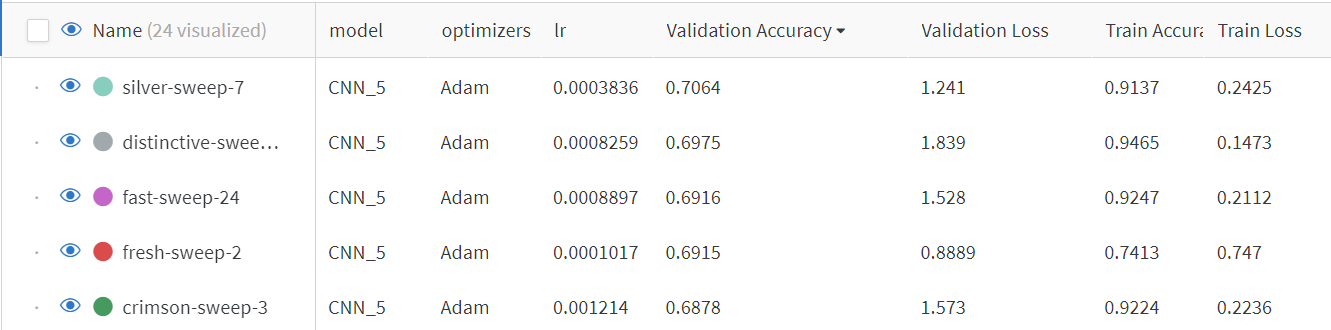


wir wollen im naechsten Schritt schauen, wie sich nun die L2 Regularisierung mit dem Optimizer Adam auswirkt und fixieren die Learning Rate auf 0.0003836. 

#### Sweep mit fixen Learning Rate und L2 Regularisierung 

In [ ]:
# define sweep configuration (Nutzen von ADAM ohne BN und ohne und mit Regularisierung)
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.0003836]
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [30]
        },
        'model': {
            'values': ['CNN_5']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'l2_reg': {
            'values': [0.001, 0.002, 0.003, 0.01, 0.02]
        },
        'optimizers': {
            'values': ['Adam']
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    l2_reg = wandb.config.l2_reg
    optimizers = wandb.config.optimizers

    if models == "CNN_5":
        model = CNN_5(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    if optimizers == "Adam":
        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=l2_reg)
        
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

#### Erkentniss aus Fixen Learning Rate und L2 Regularisierung


#### Sweep mit Fixen Learning Rate und Dropout Regularisierung

In [ ]:
# define sweep configuration (Nutzen von ADAM ohne BN und ohne und mit Regularisierung)
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.0003836]
        },
        'batch_size': {
            'values': [64]
        },
        'num_epochs': {
            'values': [30]
        },
        'model': {
            'values': ['CNN_5_dropout']
        },
        'in_out_channel': {
            'values': [43]
        },
        'kernel_size': {
            'values': [5]
        },
        'pool_size': {
            'values': [2]
        },
        'fc_nodes1': {
            'values': [95]
        },
        'fc_nodes2': {
            'values': [54]
        },
        'dropout1': {
            'values':[0, 0.1, 0.2, 0.5, 0.8]
        },
        'dropout2': {
            'values':[0, 0.1, 0.2, 0.5, 0.8]
        },
        'optimizers': {
            'values': ['Adam']
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    in_out_channel = wandb.config.in_out_channel
    kernel_size = wandb.config.kernel_size
    pool_size = wandb.config.pool_size
    fc_nodes1 = wandb.config.fc_nodes1
    fc_nodes2 = wandb.config.fc_nodes2
    dropout1 = wandb.config.dropout1
    dropout2 = wandb.config.dropout2
    optimizers = wandb.config.optimizers

    if models == "CNN_5_dropout":
        model = CNN_5_dropout(in_out_channel=in_out_channel, kernel_size=kernel_size, pool_size=pool_size, fc_nodes1=fc_nodes1, fc_nodes2=fc_nodes2, droprate1=dropout1, droprate2=dropout2).to(device)
    
    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    # create optimizer
    if optimizers == "Adam":
        optimizer = optim.Adam(model.parameters(), lr = lr)
        
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train, count = 25)
wandb.finish()

#### Erkeniss mit Fixen Learning Rate und Dropout Regularisierung

---

## Schritt 5: Präsentation, Bericht

1. Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse.
Q&A (~10min): Klärung von Verständnisfragen zu Stochastic Gradient Descent,
Parameter Tuning, Regularisierung, Batchnorm und Optimizers.

2. Bericht in Form eines (!) gut dokumentierten, übersichtlichen Jupyter Notebooks.
Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen).

---